In [182]:
from everywhereml.data import Dataset
from everywhereml.data.collect import SerialCollector
from everywhereml.preprocessing import Pipeline, MinMaxScaler, Window, SpectralFeatures
from everywhereml.sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Add the port your Arduino is connected to

Collect Training Data

In [199]:
# port = '/dev/cu.usbmodem141401'
port = 'COM7'

try:
    imu_dataset = Dataset.from_csv(
        'imu.csv', 
        name='ContinuousMotion', 
        target_name_column='target_name'
    )
    
except FileNotFoundError:
    imu_collector = SerialCollector(
        port=port, 
        baud=115200, 
        start_of_frame='IMU:', 
        feature_names=['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    )
    imu_dataset = imu_collector.collect_many_classes(
        dataset_name='ContinuousMotion', 
        duration=30
    )
    
    # save dataset to file for later use
    imu_dataset.df.to_csv('imu.csv', index=False)

print(imu_dataset.df.columns)
print(imu_dataset.df['target_name'].value_counts())

Index(['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'target', 'target_name'], dtype='object')
target_name
vertical_shake      3308
neutral             3275
punch               3268
clockwise           3240
counterclockwise    3222
horizontal_shake    3217
Name: count, dtype: int64


## Classes to Use

In [201]:
df = pd.read_csv('imu.csv')
target_num = df[df['target_name'] == 'punch']["target"].iloc[0]
df = df[df['target_name'] != 'punch']
last_target_name = df.iloc[-1]['target_name']
df.loc[df['target_name'] == last_target_name, 'target'] = target_num
imu_dataset = Dataset.from_pandas(df, name='ContinuousMotion', target_name_column='target_name')

In [202]:
# this is the frequency of your sensor
# change according to your hardware
sampling_frequency = 104
mean_gesture_duration_in_millis = 1000
window_length = sampling_frequency * mean_gesture_duration_in_millis // 1000

imu_pipeline = Pipeline(name='ContinousMotionPipeline', steps=[
    MinMaxScaler(),
    # shift can be an integer (number of samples) or a float (percent)
    Window(length=window_length, shift=0.3),
    # order can either be 1 (first-order features) or 2 (add second-order features)
    SpectralFeatures(order=2)
])

pprint(imu_pipeline['SpectralFeatures'][0].feature_names)

"""
Apply feature pre-processing
"""
imu_dataset.apply(imu_pipeline)
imu_dataset.describe()

['maximum',
 'minimum',
 'abs_maximum',
 'abs_minimum',
 'mean',
 'abs_energy',
 'mean_abs_change',
 'cid_ce',
 'std',
 'var',
 'count_above_mean',
 'count_below_mean',
 'first_position_of_max',
 'first_position_of_min',
 'max_count',
 'min_count',
 'has_large_std',
 'skew',
 'kurtosis',
 'variation_coefficient']


,ax_maximum,ax_minimum,ax_abs_maximum,ax_abs_minimum,ax_mean,ax_abs_energy,ax_mean_abs_change,ax_cid_ce,ax_std,ax_var,...,gz_count_below_mean,gz_first_position_of_max,gz_first_position_of_min,gz_max_count,gz_min_count,gz_has_large_std,gz_skew,gz_kurtosis,gz_variation_coefficient,target
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,5.220000e+02,522.000000,5.220000e+02,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,0.660672,0.404965,0.660672,0.404965,0.539997,0.303745,0.014164,5.789057e-04,0.066743,9.167890e-03,...,52.549808,49.494253,52.409962,19.017241,17.816092,0.551724,0.221380,1.182723,0.160803,2.005747
std,0.111370,0.150137,0.111370,0.150137,0.054648,0.059437,0.014098,7.972408e-04,0.068719,1.521817e-02,...,16.974589,31.626676,30.761427,32.188052,31.723080,0.497794,0.407250,1.464037,0.216948,1.420296
min,0.451613,0.000000,0.451613,0.000000,0.409828,0.169228,0.000089,4.123569e-07,0.000450,2.022326e-07,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.775613,0.000000,0.000762,0.000000
25%,0.585253,0.328341,0.585253,0.328341,0.497818,0.254091,0.002785,1.999931e-05,0.018444,3.401925e-04,...,47.000000,22.000000,27.000000,3.000000,1.250000,0.000000,0.000000,0.000000,0.034056,1.000000
50%,0.649770,0.405530,0.649770,0.405530,0.548897,0.330341,0.006868,1.745301e-04,0.033409,1.116167e-03,...,55.000000,49.000000,53.500000,5.000000,5.000000,1.000000,0.000000,0.000000,0.063941,2.000000
75%,0.707373,0.548387,0.707373,0.548387,0.587225,0.348763,0.026744,9.772859e-04,0.083549,6.980510e-03,...,61.750000,77.000000,77.000000,10.000000,12.750000,1.000000,0.280702,2.037579,0.118016,3.000000
max,1.000000,0.603687,1.000000,0.603687,0.626152,0.400909,0.057402,4.727466e-03,0.276238,7.630717e-02,...,91.000000,103.000000,103.000000,104.000000,104.000000,1.000000,2.187205,7.769925,0.708077,4.000000


In [203]:
"""
Plot features pairplot after feature extraction
Now it will start to make sense
Since SpectralFeatures generates 8 or 20 features (depending on the order)
for each axis, we limit the visualization to a more reasonable number
"""
# imu_dataset.plot.features_pairplot(n=300, k=6)

'\nPlot features pairplot after feature extraction\nNow it will start to make sense\nSince SpectralFeatures generates 8 or 20 features (depending on the order)\nfor each axis, we limit the visualization to a more reasonable number\n'

Score on test set: 0.99


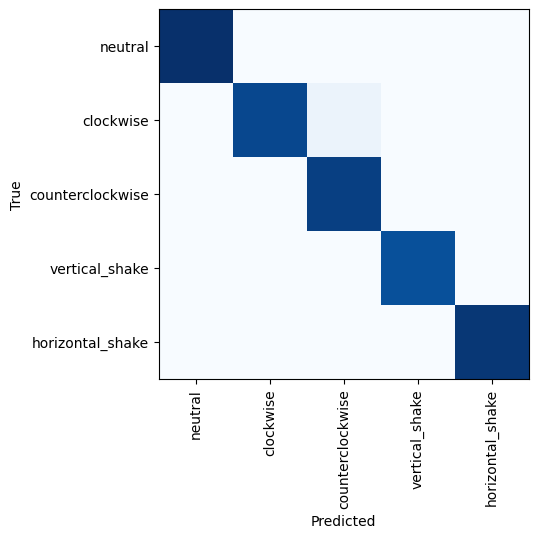

[[1.   0.   0.   0.   0.  ]
 [0.   0.91 0.06 0.   0.  ]
 [0.   0.   0.94 0.   0.  ]
 [0.   0.   0.   0.88 0.  ]
 [0.   0.   0.   0.   0.97]]


In [204]:
"""
Perform classification with a RandomForest
"""
imu_classifier = RandomForestClassifier(n_estimators=20, max_depth=20)
imu_train, imu_test = imu_dataset.split(test_size=0.3)
imu_classifier.fit(imu_train)

print('Score on test set: %.2f' % imu_classifier.score(imu_test))


# Plot confusion matrix
# If any off-diagonal values are dark, it means the gestures are too similar
# and the classifier is confusing them
df = imu_test.df
y_true = imu_test.df['target'].astype(int)
y_pred = imu_classifier.predict(imu_test.df.drop(columns=['target_name', 'target']))

mat = confusion_matrix(y_true, y_pred)
target_map = {i: name for i, name in enumerate(imu_test.target_names)}
plt.xticks(list(target_map.keys()), list(target_map.values()), rotation=90)
plt.yticks(list(target_map.keys()), list(target_map.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.imshow(mat, cmap='Blues', interpolation='nearest')
plt.show()
# round printed values to 2 decimal places
np.set_printoptions(precision=2)
print(mat / mat.max())

In [205]:
"""
Port pipeline to C++
"""
print(imu_pipeline.to_arduino_file(
    '../Arduino/IMUClassify/Pipeline.h', 
    instance_name='pipeline'
))

# Pipeline.h file has a typo. Correct this
replacement_lines = [
    "\t\t\t\t\tstep0.transform(X)\n",
    "\t\t\t\t\t\n",
    "\t\t\t\t\t&& step1.transform(X)\n",
    "\t\t\t\t\t\n",
    "\t\t\t\t\t&& step2.transform(X)\n",
]

pipeline_file = '../Arduino/IMUClassify/Pipeline.h'

with open(pipeline_file, 'r') as f:
    file_data = f.readlines()

    with open(pipeline_file, 'w') as f:
        for i, line in enumerate(file_data):
            if i >= 262 and i < 267:
                line = replacement_lines[i-262]
            f.write(line)    


"""
Port classifier to C++
"""
print(imu_classifier.to_arduino_file(
    '../Arduino/IMUClassify/Classifier.h', 
    instance_name='forest', 
    class_map=imu_dataset.class_map
))

#ifndef UUID1764054805008
#define UUID1764054805008

#include <cstring>


namespace ContinousMotionPipeline {

    
        #ifndef UUID1764147587664
#define UUID1764147587664

/**
  * MinMaxScaler(low=0, high=1)
 */
class Step0 {
    public:

        /**
         * Transform input vector
         */
        bool transform(float *x) {
            
    for (uint16_t i = 0; i < 6; i++) {
        x[i] = (x[i] - offset[i]) * scale[i] + 0;

        if (x[i] < 0) x[i] = 0;
        else if (x[i] > 1) x[i] = 1;
    }

    return true;


            return true;
        }

    protected:
        
    float offset[6] = {-1.28000000000f, -2.25000000000f, -2.04000000000f, -1058.96000000000f, -209.11000000000f, -245.97000000000f};
    float scale[6] = {0.46082949309f, 0.17006802721f, 0.20449897751f, 0.00043942523f, 0.00212282676f, 0.00195304871f};

};



#endif
    
        #ifndef UUID1764138081552
#define UUID1764138081552

/**
  * Window(length=104, shift=31)
 */
class Step1 {
    public:

     